<font size = "5"> **Chapter 3: [Imaging](CH3_00-Imaging.ipynb)** </font>
<hr style="height:1px;border-top:4px solid #FF8200" />

# Image Analysis

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM/main/Homework/Homework04-Image_Analysis.ipynb)
 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main//Homework/Homework04-Image_Analysis.ipynb)

part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>


**Spring 2024**
<table style="margin-right:auto;margin-left:0px">
  <tr>
    <td>Gerd Duscher </td>
    <td>Khalid Hattar</td>
  </tr>
  <tr>
    <td>Microscopy Facilities</td> 
    <td> Tennessee Ion Beam Materials Laboratory </td>
  </tr>
  
  <tr>
    <td>Materials Science & Engineering</td>
    <td> Nuclear Engineering</td>
  </tr>
  <tr>
    <td>Institute of Advanced Materials & Manufacturing</td>
    <td> </td>
  </tr>
  <tr>
    <td colspan="2"><center> The University of Tennessee, Knoxville</center> </td>
  </tr>
</table>

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.



## Load important packages

### Check Installed Packages

In [1]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2024.2.3':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q

print('done')

installing pyTEMlib
done


### Import all relevant libraries
Besides the ususal libraries we also load the blob detectors of the scipy-image package

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
if 'google.colab' in sys.modules:
    from google.colab import output
    from google.colab import drive
    output.enable_custom_widget_manager()

# our blob detectors from the scipy image package
from skimage.feature import blob_dog, blob_log, blob_doh

# Multidimensional Image library
import scipy.ndimage as ndimage

import time
# Import libraries from the book

import pyTEMlib
from pyTEMlib import file_tools        # File input/ output library
from pyTEMlib import image_tools 
import pyTEMlib.kinematic_scattering as ks         # Kinematic sCattering Library


# it is a good idea to show the version numbers at this point for archiving reasons.
print('pyTEM version: ',pyTEMlib.__version__)

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
SimpleITK not installed; Registration Functions for Image Stacks not available
install with: conda install -c simpleitk simpleitk 
Using kinematic_scattering library version {_version_ }  by G.Duscher
pyTEM version:  0.2024.02.2


# Load an atomic resolution image
Select the image in the widget below with **Select Main** button.

In [2]:
if 'google.colab' in sys.modules:
    drive.mount("/content/drive")

fileWidget = file_tools.FileWidget()

## Plot the Image

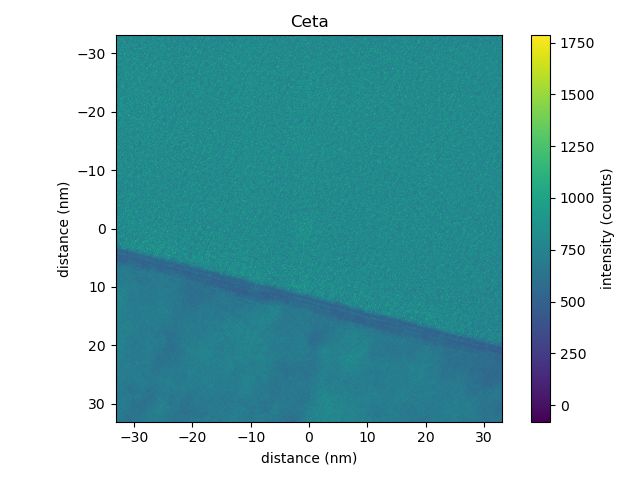

In [3]:
datasets = fileWidget.datasets
dataset = fileWidget.selected_dataset

view = dataset.plot()

## Fourier Transform of Image

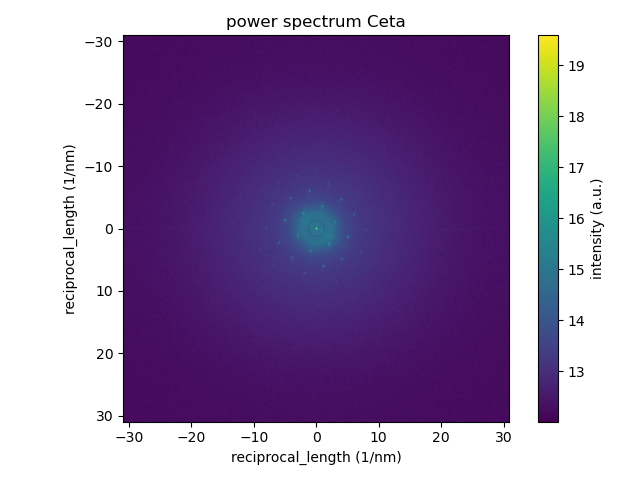

In [4]:
fft_mag = image_tools.power_spectrum(dataset)
exp_r = []
crystal_r = []
view = fft_mag.plot()

## Spot Detection
This makes sense only for a single crystalline sample.

Think about what to do next!!

Found 25 reflections


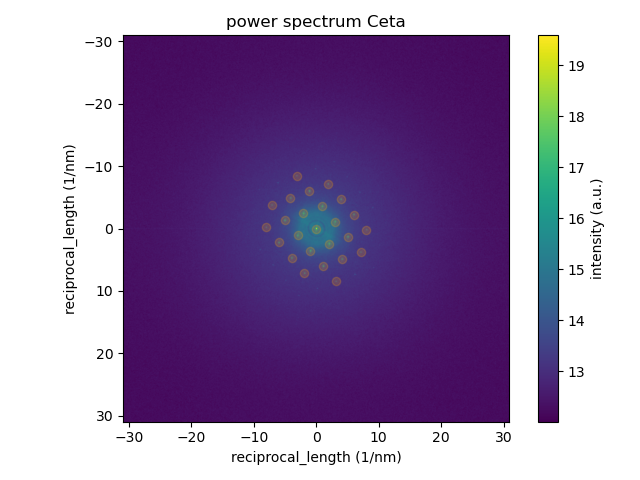

In [5]:
# ---- Input ---------
spot_threshold = .5
# --------------------
## pixel_size in recipical space
rec_scale_x = 1/dataset.x[-1]/2
rec_scale_y = 1/dataset.y[-1]/2

## Field of View (FOV) in recipical space please note: rec_FOV_x = 1/(scaleX*2)
rec_FOV_x = rec_scale_x * dataset.shape[0]
rec_FOV_y = rec_scale_y * dataset.shape[1]


## Field ofView (FOV) in recipical space
rec_extend = (-rec_FOV_x/2,rec_FOV_x/2,rec_FOV_y/2,-rec_FOV_y/2)

## Needed for conversion from pixel to Reciprocal space
rec_scale = np.array([rec_scale_x, rec_scale_y,1])
center = np.array([int(dataset.shape[0]/2), int(dataset.shape[1]/2),1] )


# spot detection ( for future referece there is no symmetry assumed here)

spots_random =  (blob_log(fft_mag,  max_sigma= 5 , threshold=spot_threshold)-center)*rec_scale

print(f'Found {spots_random.shape[0]} reflections')
spots_random[:,2] = np.linalg.norm(spots_random[:,0:2], axis=1)
spots_index = np.argsort(spots_random[:,2])
spots = spots_random[spots_index]

## plot Fourier transform and found spots
view = fft_mag.plot()
plt.gca().scatter(spots[:,0], spots[:,1], c='Orange',  alpha = 0.2, label='spots');


## Adaptive Fourier Filtering

We mask the fourier transformed image so that the information can pass through is selected.

The information is in the spots and in the center of the Fourier transformed image,the rest is noise.

Please modify the radius of the mask of the **reflections** and the **low-path** area in the code below and notice the effects on the Fourier filtered image.



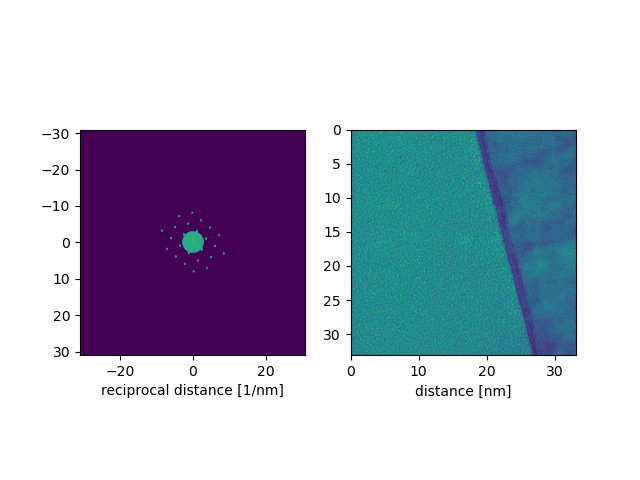

In [6]:
# Input 
reflection_radius = 0.3 # in 1/nm
low_pass = 1/.34 # in 1/nm diameter of mask for low pass filter
FOV_x = dataset.x[-1]
FOV_y = dataset.y[-1]


#prepare mask
pixels = (np.linspace(0,dataset.shape[0]-1,dataset.shape[0])-dataset.shape[0]/2)* rec_scale_x

x,y = np.meshgrid(pixels,pixels);
mask = np.zeros(dataset.shape)

# mask reflections
for spot in spots:
    mask_spot = (x-spot[0])**2+(y-spot[1])**2 < reflection_radius**2 # make a spot 
    mask = mask + mask_spot# add spot to mask
    
# mask zero region larger (low-pass filter = intensity variations)

mask_spot = x**2+y**2 < low_pass**2 
mask = mask + mask_spot

mask[np.where(mask>1)]=1 # just in case of overlapping disks

plt.figure()
ax1 = plt.subplot(1,2,1)
#ax1.imshow(mask)
fft_filtered = np.fft.fftshift(np.fft.fft2(np.array(dataset)))*mask.T
ax1.imshow(np.log(1+np.abs(fft_filtered)).real,extent=rec_extend, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]')
ax2 = plt.subplot(1,2,2)
filtered = np.fft.ifft2(np.fft.fftshift(fft_filtered).T)

real_extent = (0,FOV_x,FOV_y,0)
    
ax2.imshow(filtered.real.T,extent=real_extent, origin = 'upper')
plt.xlabel('distance [nm]');


## Check on filtered images

We don't want to filter anything out that caries information, or at least we want to be aware of that. 
An easy check is to subtract the filtered imag fromt he image and to determine that only noise is left.

Please note that any processing can be easily determined in the Fourier transformed, so be meticulous on reporting what you did to an image.


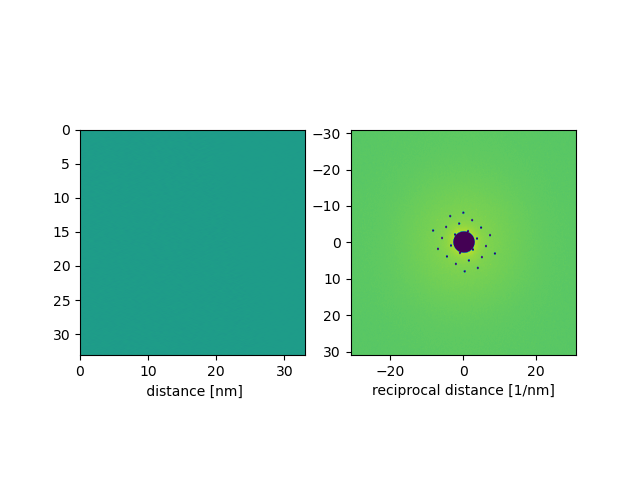

In [7]:
plt.figure()
ax1 = plt.subplot(1,2,1)
ax1.imshow(dataset-filtered.real.T,extent=real_extent, origin = 'upper')
plt.xlabel(' distance [nm]')

ax2 = plt.subplot(1,2,2)
fft_difference = np.fft.fftshift(np.fft.fft2(np.array(dataset-filtered.real.T)))
ax2.imshow(np.log(1+np.abs(fft_difference)).real,extent=rec_extend, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]');

## Rotational Symmetry

In our context of symmetry, we just need to deal with the discrete values of Θ = 2π/n for the angle of rotation.

In two dimensios we have then the rotation matrix:
$$C_{n-fold} = \left[\array{ \cos{( 2\pi/n)} & \sin{( 2\pi/n)}\\ -\sin{( 2\pi/n)} & \cos{ (2\pi/n)}\\}\right]$$

If we subtract all spots from all rotated spots we have a set of distances where for each spot there is minimal distance to the next spot.
If we have a very small distance for each original spot, we have a found rotational symmetry operation.  

In [8]:
from itertools import product

for n in [2,3,4,5,6]:
    C = np.array([[np.cos(2*np.pi/n), np.sin(2*np.pi/n),0],[-np.sin(2*np.pi/n), np.cos(2*np.pi/n),0], [0,0,1]])
    sym_spots = np.dot(spots,C)
    dif = []
    for p0, p1 in product(sym_spots[:,0:2], spots[:,0:2]):
        dif.append(np.linalg.norm(p0-p1))
    dif = np.array(sorted(dif))
    #print(dif[0:spots.shape[0]])
    if dif[int(spots.shape[0]*.7)] < 0.2:
        
        print(f'Found {n}-fold symmetry in diffraction pattern')
        

Found 2-fold symmetry in diffraction pattern


## Reference Crystals

You always are incouraged to go through this code cell!

In [13]:
# ----- Input ----- 
material = 'gold'
zone_axis =  [0,0,1]
maximum_Miller_index = 2
# -------------------

crystal  = ks.structure_by_name(material)
tags_experiment= {}
tags_experiment['acceleration_voltage_V'] = 200.0 *1000.0 #V
tags_experiment['new_figure'] = False
tags_experiment['plot FOV'] = 30
tags_experiment['convergence_angle_mrad'] = 0
tags_experiment['zone_hkl'] = np.array(zone_axis)  # incident neares zone axis: defines Laue Zones!!!!
tags_experiment['mistilt']  = np.array([0, 0, 0])  # mistilt in degrees
tags_experiment['Sg_max'] = 0.02 # 1/Ang  maximum allowed excitation error ; This parameter is related to the thickness
tags_experiment['hkl_max'] = maximum_Miller_index  # Highest evaluated Miller indices


crystal.info['experimental'] = tags_experiment
ks.kinematic_scattering(crystal, False)

##  Polar Coordinates of experimental and reference lattice
spots_crystal = crystal.info['diffraction']['allowed']['g']*10

crystal_r = np.linalg.norm(spots_crystal, axis=1)
crystal_theta = np.arctan2(spots_crystal[:,1], spots_crystal[:,0])


The diffraciton calculation is in Angstrom (or better 1/Ang) but the image is in nm.
So we convert to 1/nm

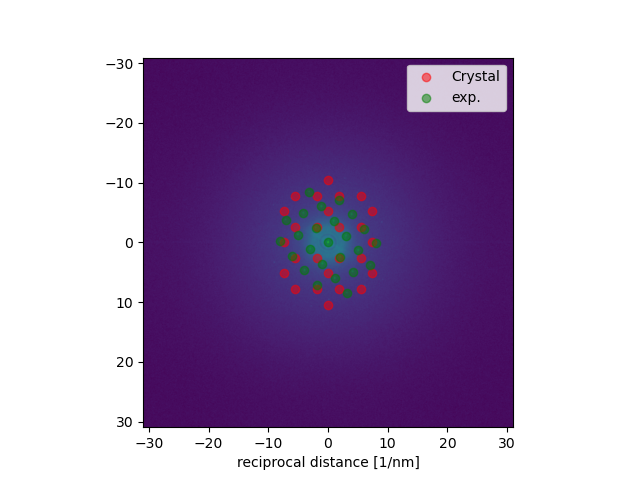

In [14]:

spots_crystal = crystal.info['diffraction']['allowed']['g']*10

resolution = 0.1#nm

plt.figure()
plt.imshow(fft_mag.T,extent=np.array(rec_extend), origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]')
plt.scatter(spots_crystal[:,0], spots_crystal[:,1], c='Red',  alpha = 0.5, label='Crystal');
if len(spots) > 0:
    plt.scatter(spots[:,0], spots[:,1], c='green',  alpha = 0.5, label='exp.');

plt.legend(loc=1);

## Reflections in Polar Coordinates 
A more interesting way of comparing a simulation and experiment is to compare the spots in polar coordinates:

conversion to Euclidean space:
$$\begin{align}
  x &= r \cos\varphi \\
  y &= r \sin\varphi
\end{align}$$

conversion to polar coordinates:
$$\begin{align}
r &= \sqrt{x^2 + y^2} \\
\varphi &= \operatorname{atan2}(y, x) 
\end{align}$$

 Rotated Crystal SAD by -50.0°


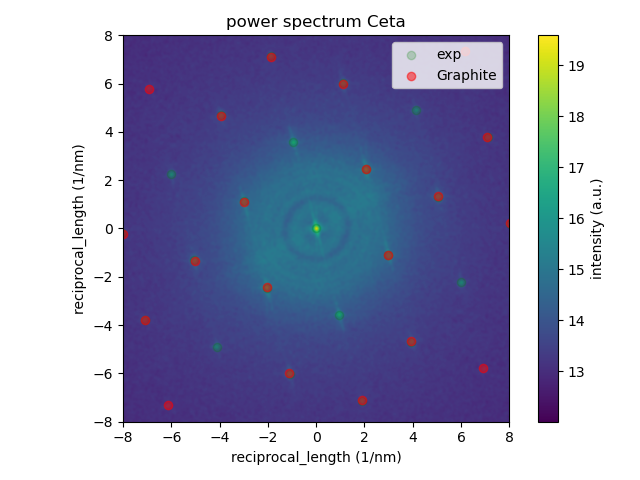

In [15]:
##  Polar Coordinates of experimental and reference lattice

def cart2pol(points):
    rho = np.linalg.norm(points[:,0:2], axis=1)
    phi = np.arctan2(points[:,1], points[:,0])
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)


def xy2polar(points, rounding = 1e-3):
    """
    Conversion from carthesian to polar coordinates
    
    the angles and distances are sorted by r and then phi
    The indices of this sort is also returned
    
    input points: numpy array with number of points in axis 0 first two elements in axis 1 are x and y
    
    optional rounding in significant digits 
    
    returns r,phi, sorted_indices
    """
    
    r,phi = cart2pol(points)
    
    phi = phi-phi.min() # only positive angles
    r = (np.floor(r/rounding) )*rounding # Remove rounding error differences

    sorted_indices = np.lexsort((phi,r) ) # sort first by r and then by phi
    r = r[sorted_indices]
    phi = phi[sorted_indices]
    
    return r, phi, sorted_indices

## Transfer everything to polar coordinates 
crystal_r, crystal_phi, crystal_indices = xy2polar(spots_crystal) #sorted by r and phi , only positive angles
exp_r, exp_phi = cart2pol(spots) # just in polar coordinates
crystal_hkl = crystal.info['diffraction']['allowed']['hkl'][crystal_indices]

angleI = np.argmin(np.abs(exp_r-crystal_r[0]) )
angle = exp_phi[angleI] - crystal_phi[0] ## Determine rotation angle

crystal_phi = crystal_phi + angle # rotation
print(f" Rotated Crystal SAD by {np.degrees(angle):.1f}°")

fft_mag.plot()

x, y= pol2cart(exp_r, exp_phi)
plt.scatter(x,y, c='green',  alpha = 0.2,label='exp')

x, y= pol2cart(crystal_r, crystal_phi)
spots_crystal[:,0] = x
spots_crystal[:,1] = y

plt.scatter(spots_crystal[:,0], spots_crystal[:,1], c='Red',  alpha = 0.5, label='Graphite');

plt.xlim(-8,8);plt.ylim(-8,8)
plt.legend(loc=1);


## Calibrate Distortions with Reference Crystal

In [16]:
g = gx = gy = rec_scale_x

spots_reference = np.array(pol2cart(crystal_r, crystal_phi)).T

spots_experiment = spots[:,0:2]
dist_crystal = np.linalg.norm(spots_reference, axis=1)

distance_experiment = np.linalg.norm(spots_experiment, axis=1)
first_reflections = abs(distance_experiment - dist_crystal.min()) < 2
print('Evaluate ', first_reflections.sum(), 'reflections')
reference_reflections = spots_experiment[first_reflections]

import scipy.optimize as optimization
def func(params, xdata, ydata):
    dgx , dgy = params
    return (np.sqrt((xdata*dgx)**2 + (ydata*dgy)**2 ) - dist_crystal.min())

x0 = [1.,0.999]
[dgx, dgy], sig = optimization.leastsq(func, x0, args=(reference_reflections[:,0], reference_reflections[:,1]))

print('distortion x:', dgx, 'y: ', dgy) 
gx /=dgx
gy /=dgy
dgy = 1.0
spots_experiment = spots_experiment*(dgx,dgy)


Evaluate  6 reflections
distortion x: 1.0413973142908703 y:  0.8723427582124673


## Plot Corrected Image and Reference Lattice

(26,)


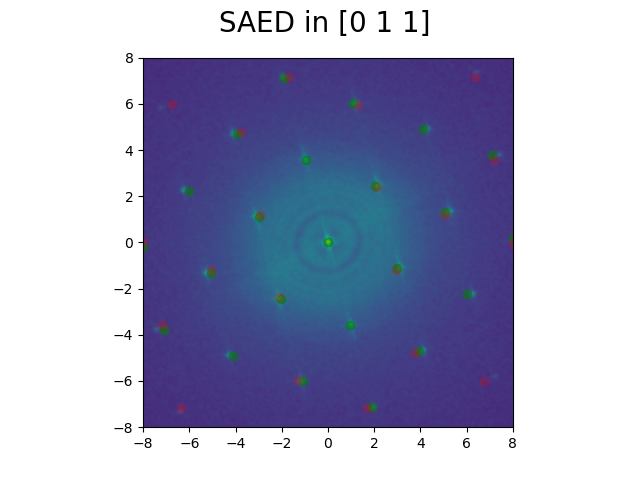

In [19]:
##  Polar Coordinates of experimental and reference lattice
FOV_cor = (0,FOV_x/dgx,FOV_y/dgy,0)
rec_FOV_cor = (-rec_FOV_x*dgx/2,rec_FOV_x*dgx/2,rec_FOV_y*dgy/2,-rec_FOV_y*dgy/2)


crystal_r = np.linalg.norm(spots_crystal, axis=1)
crystal_theta = np.arctan2(spots_crystal[:,1], spots_crystal[:,0])
print(crystal_r.shape)

crystal_theta =crystal_theta-crystal_theta.min() # only positive angles
crystal_r = (np.floor(crystal_r*1000) )/1000. # Remove rounding error differences

crystal_sorted= np.lexsort((crystal_theta,crystal_r) ) # sort first by r and then by theta
crystal_r = crystal_r[crystal_sorted]
crystal_theta = crystal_theta[crystal_sorted]

exp_r = np.linalg.norm(spots[:,0:2], axis=1)
exp_theta = np.arctan2(spots[:,1], spots[:,0])

exp_r = (np.floor(exp_r*100) )/100. # Remove rounding error differences
exp_theta = exp_theta -exp_theta.min()
exp_sorted= np.lexsort((exp_theta,exp_r) ) # sort first by r and then by theta

exp_r = exp_r[exp_sorted]
exp_theta = exp_theta[exp_sorted]

angleI = np.argmin(np.abs(exp_r-crystal_r[0]) )
angle = exp_theta[angleI] - crystal_theta[0] 

crystal_theta = crystal_theta - angle

fig = plt.figure()
fig.suptitle(' SAED in ' + str(crystal.info['experimental']['zone_hkl']), fontsize=20)     
plt.imshow(fft_mag.T,extent=rec_FOV_cor, origin = 'upper')

x = np.cos(crystal_theta)* crystal_r
y = np.sin(crystal_theta)* crystal_r

plt.scatter(spots[:,0], spots[:,1], c='green',  alpha = 0.5,
           label='spots')
plt.scatter(x,y, c='red',  alpha = 0.2,
           label='crystal')
plt.xlim(-8,8);plt.ylim(-8,8)
plt.show()


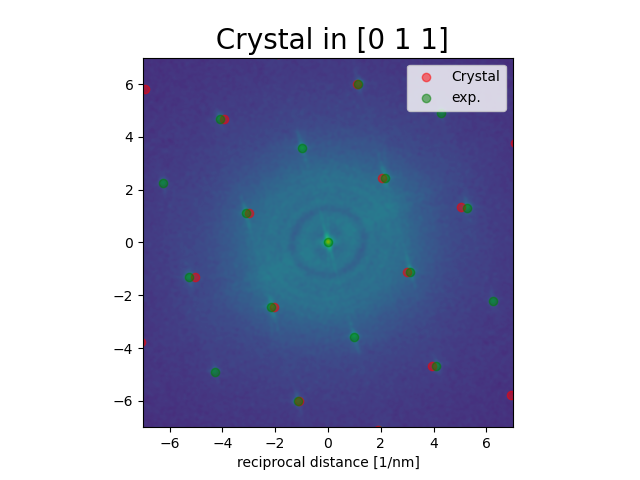

In [20]:


plt.figure()
plt.title(' Crystal in ' + str(crystal.info['experimental']['zone_hkl']), fontsize=20)     

plt.imshow(fft_mag.T,extent=rec_FOV_cor, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]')
plt.scatter(spots_crystal[:,0], spots_crystal[:,1], c='Red',  alpha = 0.5, label='Crystal');
plt.scatter(spots[:,0]*dgx, spots[:,1]*dgy, c='green',  alpha = 0.5, label='exp.');

plt.xlim(-7,7)
plt.ylim(-7,7)
plt.legend(loc=1)


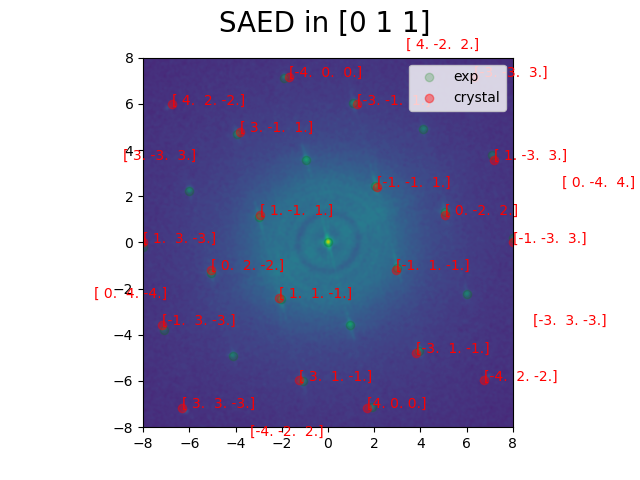

In [21]:
## Transfer everything to polar coordinates 
crystal_r, crystal_phi, crystal_indices = xy2polar(spots_crystal) #sorted by r and phi , only positive angles
exp_r, exp_phi = cart2pol(spots) # just in polar coordinates

resolution = 1/exp_r.max()
visible_crystal = crystal_r < 12


fig = plt.figure()
fig.suptitle(' SAED in ' + str(crystal.info['experimental']['zone_hkl']), fontsize=20)     
plt.imshow(fft_mag.T,extent=rec_extend, origin = 'upper')

x, y= pol2cart(exp_r, exp_phi)
plt.scatter(x,y, c='green',  alpha = 0.2,label='exp')

x, y= pol2cart(crystal_r[visible_crystal], crystal_phi[visible_crystal])
plt.scatter(x,y, c='red',  alpha = 0.4,label='crystal')

for i in range(len(crystal_r)):
    if visible_crystal[crystal_sorted[i]]:
        plt.text(x[i],y[i], str(crystal_hkl[i]), color='red')

plt.xlim(-8,8);plt.ylim(-8,8)
plt.legend(loc=1)


## Plot Histograms of Distances

Next we want to plot the radially summed profile of the diffractogram and compare it with the contrast transfer function.

### Plot Distances and CTF

Scherzer defocus is -63.4 nm


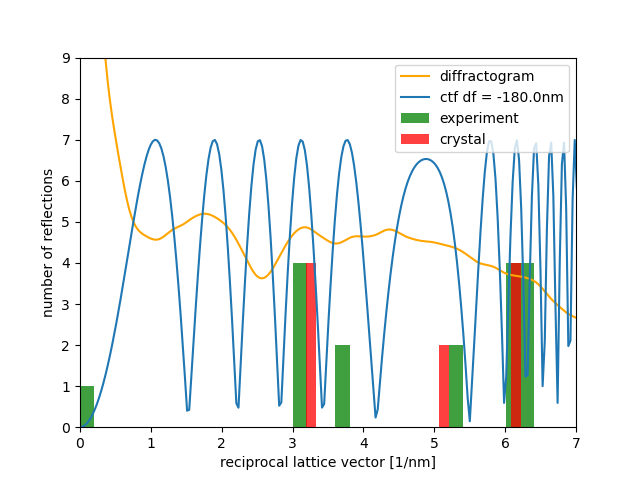

In [22]:
# --------- Input -----------
Cs = 1.2
defocus = -180 # underfocus is negative
acceleration_voltage = 200*1e3
scale_CTF = 7
# ---------------------------------
wavelength = ks.get_wavelength(acceleration_voltage) # in Angstrom

## pixel_size in recipical space
rec_scale_x = 1/dataset.x[-1]  

polar_projection = image_tools.warp(fft_mag).T
below_zero = polar_projection<0.
polar_projection[below_zero]=0.

# Sum over all angles (axis 1)
profile = polar_projection.sum(axis=1)
profile = (profile-profile[1:400].min())/profile.max()*10

k =np.linspace(1,len(profile),len(profile))*rec_scale_x

def calculateScherzer(wavelength, Cs):
    # Calculate the Scherzer defocus. Cs is in mm, lambda is in nm
    # Everything is trasnfered to m
    #The returned value is in nm
    Cs=Cs*1e-3 # now in m
    scherzer=-1.155*(Cs*wavelength*1e-10)**0.5 # in m
    scherzer=scherzer*1e9 # convert to nm
    return scherzer

scherzer =calculateScherzer(wavelength, Cs)

print(f'Scherzer defocus is {scherzer:.1f} nm')

def calculateCTF(wavelength, Cs, defocus,k3):
    # everything in nm
    Cs=Cs*10**6
    ctf=np.sin(np.pi*defocus*wavelength*k**2+0.5*np.pi*Cs*wavelength**3*k**4)
    return ctf
ctf = calculateCTF(wavelength/10, Cs, defocus,k)


fig = plt.figure()
plt.plot(k,profile/profile.max()*20,c='orange',label='diffractogram' );
plt.plot(k,np.abs(ctf)*scale_CTF, label = f'ctf df = {defocus:.1f}nm')
if len(exp_r) > 0:
  plt.hist(exp_r,45,facecolor='green', alpha=0.75, label='experiment')
if len(crystal_r) > 0:
  plt.hist(crystal_r,50,facecolor='red', alpha=0.75, linewidth=4, label='crystal')

plt.legend()
plt.xlabel('reciprocal lattice vector [1/nm]')
plt.ylabel('number of reflections')

plt.ylim(0,9)
plt.xlim(0,7)
plt.show()